In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import chainer
from chainer import links as L
from chainer import functions as F
from chainer import optimizers

from generate_input import load_images_from_folder

from chainer import reporter

from chainer import backend
from chainer import backends
from chainer.backends import cuda
from chainer import Function, gradient_check, report, training, utils, Variable
from chainer import  initializers, iterators, optimizers, serializers
from chainer.training import extensions

import numpy as np

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
class MRICNN(chainer.Chain):
    def __init__(self, x_shape):
        super(MRICNN, self).__init__()
        size=(64, 1, 5, 5)
        n = size[0] * size[2] * size[3] + size[1] * size[2] * size[3]
        a = np.sqrt(6/n)
        W1 = self.xp.random.uniform(high=a, low=a, size=size)

        size=(64, 64, 5, 5)
        n = size[0] * size[2] * size[3] + size[1] * size[2] * size[3]
        a = np.sqrt(6/n)
        W2 = self.xp.random.uniform(high=a, low=a, size=size)
        
        size=(64, 1, 7, 7)
        n = size[0] * size[2] * size[3] + size[1] * size[2] * size[3]
        a = np.sqrt(6/n)
        W3 = self.xp.random.uniform(high=a, low=a, size=size)
        
        
        with self.init_scope():
            n_out = int(x_shape[0]*x_shape[1])
            self.fc1 = L.Linear(None, n_out)
            self.bn1 = L.BatchNormalization(None, axis=(0))
            self.fc2 = L.Linear(None, n_out)
            self.bn2 = L.BatchNormalization(None, axis=(0))
#             self.conv1 = L.Convolution2D(in_channels=1, out_channels=64, ksize=3, pad=2)
#             self.conv2 = L.Convolution2D(in_channels=64,out_channels=64, ksize=3, pad=2)
#             self.deconv = L.Deconvolution2D(in_channels=64, out_channels=1, ksize=5)

            self.conv1  = L.Convolution2D(in_channels=1, out_channels=64, ksize=5, pad=4)
            self.bn3 = L.BatchNormalization(None, axis=(0))
            self.conv2  = L.Convolution2D(in_channels=64,out_channels=64, ksize=5, pad=4)
            self.bn4 = L.BatchNormalization(None, axis=(0))
            self.deconv = L.Deconvolution2D(in_channels=64, out_channels=1, ksize=7)

#             self.conv1 = L.Convolution2D(in_channels=1, out_channels=64, ksize=5, initialW=W1, pad=4)
#             self.conv2 = L.Convolution2D(in_channels=64, out_channels=64, ksize=5, initialW=W2, pad=4)
#             self.deconv = L.Deconvolution2D(in_channels=64, out_channels=1, ksize=7, initialW=W3)
        
    def __call__(self, x):
        h = x.reshape(x.shape[0], -1)
        
        h = self.fc1(h)
        h = F.tanh(h)
        h = self.bn1(h)
        
        h = self.fc2(h)
        h = F.tanh(h)
        h = self.bn2(h)
        h = h.reshape(x.shape[0], 1, x.shape[1], x.shape[2])
#         print(h.shape)
        h = self.conv1(h)
        h = F.relu(h)
        h = self.bn3(h)
#         print(h.shape)
        h = self.conv2(h)
        h = F.relu(h)
        h = self.bn4(h)
#         print(h.shape)
        h = self.deconv(h)
        h = h[:, :, 7:-7, 7:-7]
#         print(h.shape)
        
        return h


In [5]:
def compute_cost(x, y):
    x = x[:, 0, :, :]
    cost = F.mean_squared_error(x, y)
    return cost

In [6]:
class Minimizer(chainer.Chain):
    def __init__(self, model, loss_fun):
        super(Minimizer, self).__init__()
        with self.init_scope():
            self.model = model
            
        self.loss_fun = loss_fun
        self.noise = True
        self.report = True
        
    def forward(self, *args):
        if self.noise:
            noise = self.xp.random.normal(size=args[0].shape)
            noise = noise.astype(np.float32)
        else:
            noise = 0
        self.y = self.model(args[0] + noise)
        self.loss = self.loss_fun(self.y, args[1])
        if self.report:
            reporter.report({'loss':self.loss}, self)
        return self.loss

In [7]:
%%time
dir_train = '/home/genta/dataset/tiny-imagenet-200/test/images/'  # Folder with images
n_im = 10000  # How many images to load
X_train, Y_train = load_images_from_folder(  # Load images for training
    dir_train,
    n_im,
    normalize=False,
    imrotate=True,
    search_dirs = None,
    transform='fourier',
    size=(110, 110)
)
print('X_train.shape at input = ', X_train.shape)
print('Y_train.shape at input = ', Y_train.shape)

X_train.shape at input =  (40000, 110, 110, 2)
Y_train.shape at input =  (40000, 110, 110)


In [8]:
print(X_train.max(), X_train.min(), X_train.mean())
print(Y_train.max(), Y_train.min(), Y_train.mean())

2948419.0 -775505.788114 56.302675
255.0 0.0 113.30800438


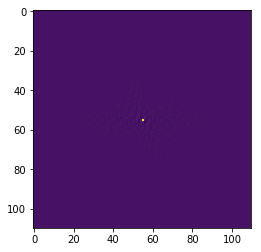

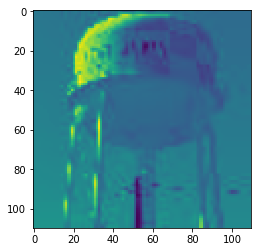

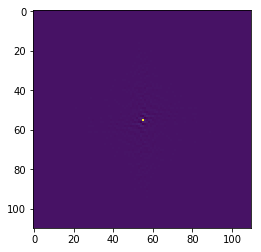

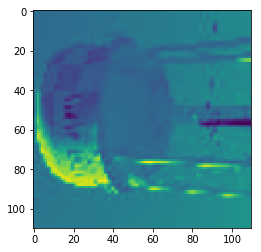

In [9]:
plt.imshow(X_train[0][:, :, 0])
plt.show()

plt.imshow(Y_train[0])
plt.show()

plt.imshow(X_train[1][:, :, 0])
plt.show()

plt.imshow(Y_train[1])
plt.show()

In [10]:
X_train = X_train.astype(np.float32)
# X_train = X_train - X_train.min()
# X_train /= X_train.max()
Y_train = Y_train.astype(np.float32)
Y_train = Y_train - Y_train.min()
Y_train /= Y_train.max()

In [11]:
print(X_train.max(), X_train.min(), X_train.mean())
print(Y_train.max(), Y_train.min(), Y_train.mean())

2.94842e+06 -775506.0 56.3026
1.0 0.0 0.444344


In [12]:
n_test = X_train.shape[0]//4
train = [(i, j) for i, j in zip(X_train[n_test:, :], Y_train[n_test:, :])]
test = [(i, j) for i, j in zip(X_train[:n_test, :], Y_train[:n_test, :])]

In [13]:
len(train), len(test)

(30000, 10000)

In [23]:
def main():
    max_epoch = 10
    gpu_id = 0
    lr = 0.0002
    batchsize = 100

    train_iter = iterators.SerialIterator(train, batchsize)
    test_iter = iterators.SerialIterator(test, batchsize, False, False)

    preditor = MRICNN(X_train[0].shape)
    preditor.to_gpu(0)
    model = Minimizer(preditor, compute_cost)
    optimizer = optimizers.RMSprop(lr=lr, alpha=0.9)
#     optimizer = optimizers.MomentumSGD(lr=lr, momentum=0.9)
#     optimizer = optimizers.Adam(alpha=lr)
#     optimizer = optimizers.NesterovAG(lr=lr)
    optimizer.setup(model)
    optimizer.add_hook(chainer.optimizer_hooks.Lasso(0.0001))

    updater = training.updaters.StandardUpdater(train_iter, optimizer, device=gpu_id)
    trainer = training.Trainer(updater, (max_epoch, 'epoch'), out='result')
    trainer.extend(extensions.LogReport())
    trainer.extend(extensions.snapshot_object(model.model, filename='model_epoch-{.updater.epoch}'),
                   trigger=training.triggers.IntervalTrigger(5, unit='epoch'))
    trainer.extend(extensions.Evaluator(test_iter, model, device=gpu_id))
    trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'validation/main/loss', 'elapsed_time']))
    trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'], x_key='epoch', file_name='loss.png'))
    trainer.extend(extensions.dump_graph('main/loss'))
    return trainer, optimizer

In [24]:
trainer, optimizer = main()

In [25]:
%%time
trainer.run()

epoch       main/loss   validation/main/loss  elapsed_time
1           5.90639     0.583422              113.809       
2           0.394804    0.181329              229.06        
3           0.237062    0.209813              344.673       
4           0.180307    0.124702              460.518       
5           0.141848    0.0754512             576.477       
6           0.109096    0.0666511             776.925       
7           0.092659    0.0699533             892.772       
8           0.0826593   0.128806              1008.52       
9           0.078272    0.0598631             1123.98       
10          0.0720622   0.0586503             1239.35       
CPU times: user 14min 51s, sys: 7min 3s, total: 21min 54s
Wall time: 22min 2s


In [26]:
train[0][1]

array([[ 0.87058824,  0.88235295,  0.90196079, ...,  0.87058824,
         0.90196079,  0.9254902 ],
       [ 0.8509804 ,  0.86274511,  0.88235295, ...,  0.86274511,
         0.88235295,  0.89019608],
       [ 0.81960785,  0.83137256,  0.8509804 , ...,  0.85882354,
         0.84705883,  0.8392157 ],
       ..., 
       [ 0.96078432,  0.93333334,  0.88627452, ...,  0.87450981,
         0.85882354,  0.84705883],
       [ 0.93725491,  0.91764706,  0.89019608, ...,  0.87843138,
         0.86666667,  0.85490197],
       [ 0.92156863,  0.90980393,  0.89019608, ...,  0.88627452,
         0.87058824,  0.86274511]], dtype=float32)

In [27]:
model = optimizer.target

model.to_cpu()

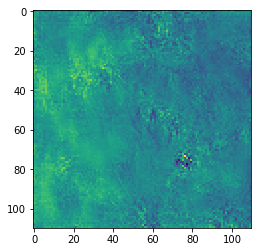

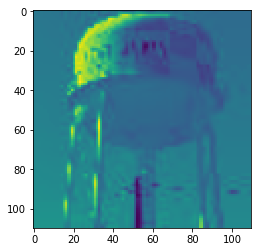

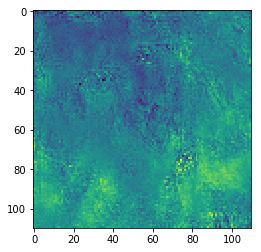

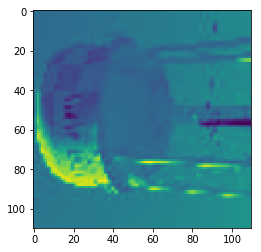

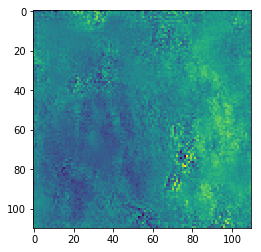

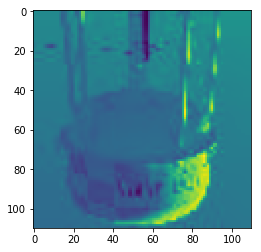

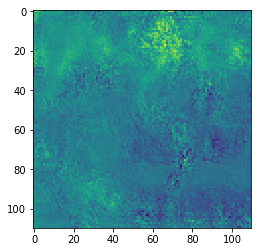

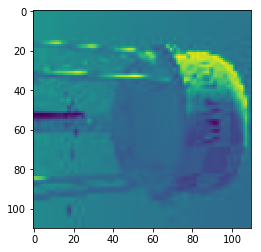

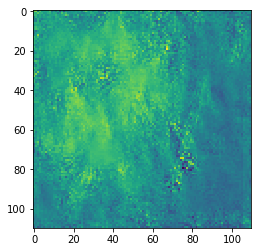

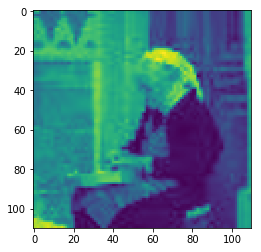

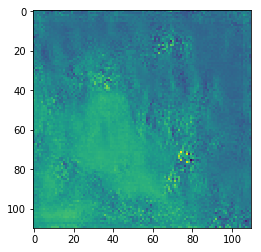

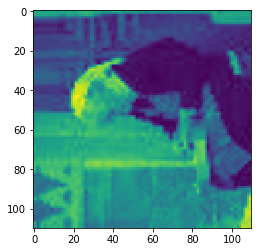

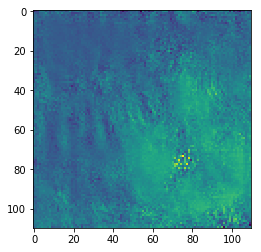

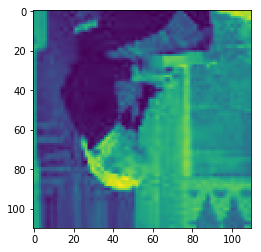

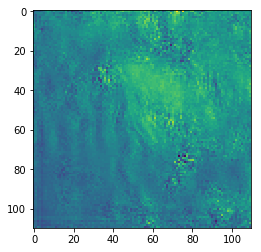

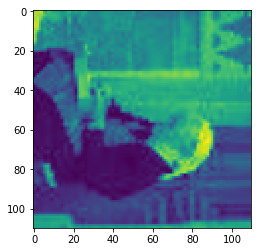

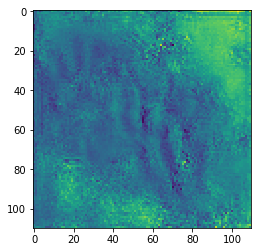

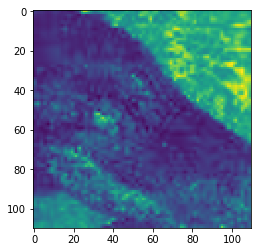

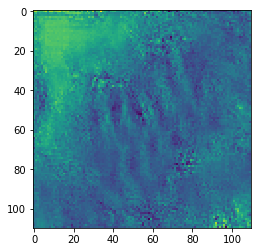

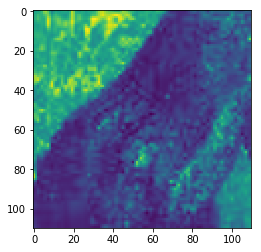

In [28]:
out = model.model(X_train[:10])

for i in range(10):
    plt.imshow(out.data[i, 0])
    plt.show()
    plt.imshow(Y_train[i])
    plt.show()

In [14]:
import optuna

In [15]:
print(n_test)

10000


In [16]:
def objective(trial):
    gpu_id = 0
    batchsize = 100
#     max_epoch = trial.suggest_discrete_uniform('max_epoch', 1, 5, 1)
    max_epoch = 20
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
    alpha = trial.suggest_uniform('alpha', 0.85, 1)
    lasso_alpha = trial.suggest_loguniform('lass_alpha', 1e-5, 1e-3)
    print('trial ', trial.number)
    print('max_epoch\t', max_epoch)
    print('lr\t', lr)
    print('alpha\t', alpha)
    print('lasso_alpha\t', lasso_alpha)

    train_iter = iterators.SerialIterator(train, batchsize)
    test_iter = iterators.SerialIterator(test, batchsize, False, False)

    preditor = MRICNN(X_train[0].shape)
    preditor.to_gpu(0)
    model = Minimizer(preditor, compute_cost)
    optimizer = optimizers.RMSprop(lr=lr, alpha=alpha)
    optimizer.setup(model)
#     optimizer.add_hook(chainer.optimizer_hooks.Lasso(lasso_alpha))

    updater = training.updaters.StandardUpdater(train_iter, optimizer, device=gpu_id)
    trainer = training.Trainer(updater, (max_epoch, 'epoch'), out='result')
    trainer.extend(extensions.Evaluator(test_iter, model, device=gpu_id))
    trainer.extend(extensions.snapshot_object(model.model, filename='model_num{}'.format(trial.number)),
               trigger=training.triggers.IntervalTrigger(max_epoch, unit='epoch'))

    trainer.extend(extensions.LogReport())
    trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'validation/main/loss', 'elapsed_time']))
    trainer.run()
    
    loss = []
    model.noise = False
    model.report = False
    for i in range(0, n_test, 100):
        x = X_train[i:i+100]
        y = Y_train[i:i+100]
        t = model(cuda.to_gpu(x), cuda.to_gpu(y))
        loss.append(cuda.to_cpu(t.data))
    loss = np.asarray(loss)
    loss = loss.sum() / n_test
    print(loss)
    return loss

In [17]:
%%time

study = optuna.create_study()
study.optimize(objective, n_trials=20)

trial  0
max_epoch	 20
lr	 5.2432310582e-05
alpha	 0.9296877689601148
lasso_alpha	 0.000795824638526
epoch       main/loss   validation/main/loss  elapsed_time
1           6.77511     0.195318              109.454       
2           0.108448    0.0723817             218.837       
3           0.0637673   0.0525721             328.272       
4           0.0469794   0.0377902             437.869       
5           0.0381306   0.0302617             547.577       
6           0.0338059   0.0318007             657.361       
7           0.0312045   0.0256716             767.223       
8           0.0296501   0.0243845             877.1         
9           0.0280404   0.0248508             987.157       
10          0.0272675   0.0263314             1097.25       
11          0.0266525   0.0238407             1207.03       
12          0.0260199   0.0228583             1316.75       
13          0.0250915   0.0219858             1426.16       
14          0.0249268   0.0232048             1

[I 2019-04-08 23:49:27,800] Finished trial#0 resulted in value: 0.000511264705657959. Current best value is 0.000511264705657959 with parameters: {'lr': 5.2432310581989775e-05, 'alpha': 0.9296877689601148, 'lass_alpha': 0.00079582463852571027}.


trial  1
max_epoch	 20
lr	 0.000659893877205
alpha	 0.9927915170760968
lasso_alpha	 1.34795494609e-05
epoch       main/loss   validation/main/loss  elapsed_time
1           7.1796      1.96229               108.549       
2           0.934797    0.917252              217.634       
3           0.745976    0.299538              326.761       
4           0.577382    0.610451              435.706       
5           0.522983    0.810837              544.257       
6           0.468064    0.519155              652.558       
7           0.412834    0.335897              760.724       
8           0.327417    0.349992              868.804       
9           0.275665    0.323943              977.035       
10          0.237487    0.279175              1085.43       
11          0.213826    0.690307              1193.97       
12          0.207298    0.137998              1302.56       
13          0.18342     0.444255              1411.16       
14          0.180993    0.239179              

[I 2019-04-09 00:27:10,384] Finished trial#1 resulted in value: 0.0013559481620788573. Current best value is 0.000511264705657959 with parameters: {'lr': 5.2432310581989775e-05, 'alpha': 0.9296877689601148, 'lass_alpha': 0.00079582463852571027}.


trial  2
max_epoch	 20
lr	 1.65881702268e-05
alpha	 0.9683968826426301
lasso_alpha	 0.000477749070595
epoch       main/loss   validation/main/loss  elapsed_time
1           20.8812     7.86375               108.432       
2           2.68086     0.788904              217.301       
3           0.431205    0.245592              326.015       
4           0.193664    0.149271              434.753       
5           0.12879     0.101159              543.443       
6           0.100343    0.0870334             652.225       
7           0.0829183   0.076891              761.239       
8           0.0718261   0.0648731             870.17        
9           0.0634433   0.0574748             979.191       
10          0.0576174   0.0561125             1088.13       
11          0.0526269   0.0547666             1196.86       
12          0.0481268   0.0470292             1305.32       
13          0.0435078   0.0419629             1413.69       
14          0.0397458   0.0375442             

[I 2019-04-09 01:04:55,856] Finished trial#2 resulted in value: 0.00033459715843200683. Current best value is 0.00033459715843200683 with parameters: {'lr': 1.6588170226773278e-05, 'alpha': 0.9683968826426301, 'lass_alpha': 0.00047774907059481908}.


trial  3
max_epoch	 20
lr	 5.77649280283e-05
alpha	 0.9086274130042717
lasso_alpha	 4.098409171e-05
epoch       main/loss   validation/main/loss  elapsed_time
1           8.39717     0.752127              108.801       
2           0.418804    0.226589              218.025       
3           0.191468    0.21894               327.354       
4           0.13627     0.090916              436.444       
5           0.111045    0.0950668             545.198       
6           0.096819    0.0751508             653.994       
7           0.0872001   0.0727586             762.679       
8           0.0804877   0.0718192             871.394       
9           0.0749172   0.0585407             980.229       
10          0.0700885   0.0639095             1089.18       
11          0.0661187   0.0703689             1198.27       
12          0.0627377   0.0551453             1307.44       
13          0.0602318   0.0564392             1416.68       
14          0.0572437   0.077424              15

[I 2019-04-09 01:42:48,042] Finished trial#3 resulted in value: 0.0003993024587631226. Current best value is 0.00033459715843200683 with parameters: {'lr': 1.6588170226773278e-05, 'alpha': 0.9683968826426301, 'lass_alpha': 0.00047774907059481908}.


trial  4
max_epoch	 20
lr	 0.000119582801903
alpha	 0.9203819044946678
lasso_alpha	 1.06106118508e-05
epoch       main/loss   validation/main/loss  elapsed_time
1           5.59697     0.378516              108.04        
2           0.245894    0.191412              216.384       
3           0.158918    0.128833              324.892       
4           0.132686    0.0973058             433.634       
5           0.117399    0.109556              542.541       
6           0.108096    0.0701589             651.445       
7           0.100056    0.0971682             760.381       
8           0.0944033   0.065361              869.413       
9           0.0869398   0.056233              978.463       
10          0.0812757   0.0687431             1087.58       
11          0.0767979   0.0371022             1196.41       
12          0.0724987   0.0786015             1304.9        
13          0.0705338   0.0431432             1413.34       
14          0.0680267   0.0842352             

[I 2019-04-09 02:20:33,714] Finished trial#4 resulted in value: 0.0006071327209472657. Current best value is 0.00033459715843200683 with parameters: {'lr': 1.6588170226773278e-05, 'alpha': 0.9683968826426301, 'lass_alpha': 0.00047774907059481908}.


trial  5
max_epoch	 20
lr	 0.00045628702012
alpha	 0.9980537702731853
lasso_alpha	 0.000173478677205
epoch       main/loss   validation/main/loss  elapsed_time
1           9.60285     1.86649               109.041       
2           1.34922     0.858228              218.383       
3           0.808644    0.613459              327.904       
4           0.614235    0.459166              437.344       
5           0.50556     0.51149               546.735       
6           0.438286    0.416755              656.075       
7           0.382718    0.358675              765.365       
8           0.34292     0.31875               874.7         
9           0.314935    0.285903              984.02        
10          0.280849    0.298784              1093.35       
11          0.257446    0.244846              1202.68       
12          0.238323    0.194598              1312.08       
13          0.217189    0.208343              1421.49       
14          0.200289    0.212514              1

[I 2019-04-09 02:58:33,511] Finished trial#5 resulted in value: 0.0010190834045410155. Current best value is 0.00033459715843200683 with parameters: {'lr': 1.6588170226773278e-05, 'alpha': 0.9683968826426301, 'lass_alpha': 0.00047774907059481908}.


trial  6
max_epoch	 20
lr	 0.000851171355685
alpha	 0.8755749940831319
lasso_alpha	 0.000438276650569
epoch       main/loss   validation/main/loss  elapsed_time
1           7.59737     1.81386               108.823       
2           1.31007     0.986199              218.181       
3           0.634453    0.362954              327.502       
4           0.402487    0.358123              436.919       
5           0.293106    0.25429               546.313       
6           0.228113    0.247752              655.73        
7           0.18619     0.167465              765.131       
8           0.15711     0.143129              874.56        
9           0.135495    0.104171              984.093       
10          0.119703    0.104281              1093.52       
11          0.107085    0.0981363             1203.08       
12          0.0972924   0.105826              1312.46       
13          0.0890626   0.0896783             1421.87       
14          0.0825042   0.0849193             

[I 2019-04-09 03:36:33,545] Finished trial#6 resulted in value: 0.0006365872383117675. Current best value is 0.00033459715843200683 with parameters: {'lr': 1.6588170226773278e-05, 'alpha': 0.9683968826426301, 'lass_alpha': 0.00047774907059481908}.


trial  7
max_epoch	 20
lr	 4.77181864393e-05
alpha	 0.8547196472666065
lasso_alpha	 0.000133967613653
epoch       main/loss   validation/main/loss  elapsed_time
1           9.44854     0.84296               109.111       
2           0.454798    0.271577              218.433       
3           0.218438    0.154392              327.995       
4           0.15471     0.14775               437.456       
5           0.124596    0.130894              546.823       
6           0.106607    0.138322              656.218       
7           0.0940102   0.0840637             765.526       
8           0.0847093   0.0776556             874.838       
9           0.078155    0.0663552             984.149       
10          0.0723539   0.0662321             1093.48       
11          0.0681543   0.0595068             1202.82       
12          0.0645818   0.0641977             1312.13       
13          0.0614577   0.0561128             1421.53       
14          0.0587192   0.0603729             

[I 2019-04-09 04:14:32,981] Finished trial#7 resulted in value: 0.0006519983768463135. Current best value is 0.00033459715843200683 with parameters: {'lr': 1.6588170226773278e-05, 'alpha': 0.9683968826426301, 'lass_alpha': 0.00047774907059481908}.


trial  8
max_epoch	 20
lr	 0.000431406321778
alpha	 0.8749321837167304
lasso_alpha	 0.000112028125464
epoch       main/loss   validation/main/loss  elapsed_time
1           7.04492     2.49823               108.921       
2           1.15788     0.737859              218.228       
3           0.623166    0.49649               327.562       
4           0.460716    0.452675              436.864       
5           0.379531    0.313345              546.275       
6           0.329106    0.249469              655.671       
7           0.295227    0.275767              765.086       
8           0.269803    0.238504              874.482       
9           0.249415    0.260555              983.882       
10          0.232773    0.198947              1093.28       
11          0.220081    0.19338               1202.84       
12          0.207443    0.238178              1312.24       
13          0.197035    0.199591              1421.62       
14          0.188153    0.171296              

[I 2019-04-09 04:52:32,096] Finished trial#8 resulted in value: 0.0011746567726135253. Current best value is 0.00033459715843200683 with parameters: {'lr': 1.6588170226773278e-05, 'alpha': 0.9683968826426301, 'lass_alpha': 0.00047774907059481908}.


trial  9
max_epoch	 20
lr	 0.000186694053755
alpha	 0.9944022274187553
lasso_alpha	 0.000193265126668
epoch       main/loss   validation/main/loss  elapsed_time
1           8.13667     3.25652               109.113       
2           2.2262      1.3907                218.528       
3           1.02678     0.699841              328.028       
4           0.640326    0.429473              437.484       
5           0.420532    0.328572              546.87        
6           0.292409    0.28234               656.221       
7           0.242687    0.194866              765.587       
8           0.20554     0.177507              874.901       
9           0.180976    0.141207              984.186       
10          0.165957    0.116086              1093.51       
11          0.152877    0.234109              1202.81       
12          0.143231    0.126736              1312.21       
13          0.138635    0.0933881             1421.6        
14          0.124444    0.126231              

[I 2019-04-09 05:30:32,207] Finished trial#9 resulted in value: 0.0008289211273193359. Current best value is 0.00033459715843200683 with parameters: {'lr': 1.6588170226773278e-05, 'alpha': 0.9683968826426301, 'lass_alpha': 0.00047774907059481908}.


trial  10
max_epoch	 20
lr	 1.10738014956e-05
alpha	 0.956724321468
lasso_alpha	 0.000404888166637
epoch       main/loss   validation/main/loss  elapsed_time
1           23.3259     6.8909                108.814       
2           2.59575     0.898138              217.837       
3           0.52341     0.294275              326.796       
4           0.204685    0.151885              435.677       
5           0.120389    0.105462              544.644       
6           0.0880296   0.0809212             653.637       
7           0.0710147   0.0648659             762.553       
8           0.0610867   0.057756              871.564       
9           0.0547539   0.0531937             980.547       
10          0.0500582   0.0491479             1089.65       
11          0.0460451   0.0445317             1198.77       
12          0.0421575   0.0410291             1307.78       
13          0.0378451   0.0366762             1416.58       
14          0.0339943   0.033535              152

[I 2019-04-09 06:08:22,930] Finished trial#10 resulted in value: 0.0002769323825836182. Current best value is 0.0002769323825836182 with parameters: {'lr': 1.1073801495582516e-05, 'alpha': 0.95672432146755226, 'lass_alpha': 0.00040488816663677404}.


trial  11
max_epoch	 20
lr	 1.313398278e-05
alpha	 0.953413542765
lasso_alpha	 4.0771699686e-05
epoch       main/loss   validation/main/loss  elapsed_time
1           22.8216     12.2638               109.095       
2           5.94071     1.66116               218.489       
3           0.865098    0.445028              327.881       
4           0.326691    0.225072              437.272       
5           0.190006    0.145642              546.637       
6           0.134663    0.112702              656.01        
7           0.106406    0.0964232             765.307       
8           0.0888312   0.0813901             874.585       
9           0.0775259   0.0708238             983.882       
10          0.0690033   0.0644124             1093.18       
11          0.0628396   0.0608131             1202.51       
12          0.0578218   0.0568718             1311.8        
13          0.0537463   0.0553602             1421.1        
14          0.0505786   0.0515845             1530.4

Exception in main training loop: Failed to write to /tmp/tmp52jy51w8-numpy.npy: [Errno 28] No space left on device
Traceback (most recent call last):
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/chainer/lib/python3.6/site-packages/chainer/training/trainer.py", line 318, in run
    entry.extension(self)
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/chainer/lib/python3.6/site-packages/chainer/training/extensions/_snapshot.py", line 39, in snapshot_object
    _snapshot_object(trainer, target, filename.format(trainer), savefun)
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/chainer/lib/python3.6/site-packages/chainer/training/extensions/_snapshot.py", line 87, in _snapshot_object
    savefun(tmppath, target)
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/chainer/lib/python3.6/site-packages/chainer/serializers/npz.py", line 74, in save_npz
    save_npz(f, obj, compression)
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/chainer/lib/python3.6/si

trial  12
max_epoch	 20
lr	 1.18295081468e-05
alpha	 0.95532528786
lasso_alpha	 4.59508412433e-05
epoch       main/loss   validation/main/loss  elapsed_time
1           25.189      13.7292               109.356       
2           7.86615     3.11619               218.671       
3           1.67438     0.868949              327.948       
4           0.638886    0.429777              437.246       
5           0.369442    0.277169              546.544       
6           0.259192    0.207766              655.934       
7           0.202384    0.165788              765.305       
8           0.166616    0.13904               874.699       
9           0.143053    0.122335              984.079       
10          0.126087    0.109608              1093.46       
11          0.112875    0.096715              1202.84       
12          0.102496    0.0887036             1312.23       
13          0.0941727   0.0824785             1421.62       
14          0.0875367   0.0769123             1530

Exception in main training loop: Failed to write to /tmp/tmpmsh0ll3b-numpy.npy: [Errno 28] No space left on device
Traceback (most recent call last):
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/chainer/lib/python3.6/site-packages/chainer/training/trainer.py", line 318, in run
    entry.extension(self)
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/chainer/lib/python3.6/site-packages/chainer/training/extensions/_snapshot.py", line 39, in snapshot_object
    _snapshot_object(trainer, target, filename.format(trainer), savefun)
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/chainer/lib/python3.6/site-packages/chainer/training/extensions/_snapshot.py", line 87, in _snapshot_object
    savefun(tmppath, target)
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/chainer/lib/python3.6/site-packages/chainer/serializers/npz.py", line 74, in save_npz
    save_npz(f, obj, compression)
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/chainer/lib/python3.6/si

trial  13
max_epoch	 20
lr	 1.27336203726e-05
alpha	 0.954875657951
lasso_alpha	 4.34831826771e-05
epoch       main/loss   validation/main/loss  elapsed_time
1           20.9083     7.68797               109.475       
2           2.45684     0.61429               218.752       
3           0.32739     0.183341              327.821       
4           0.136664    0.10238               436.897       
5           0.0877731   0.0752319             545.941       
6           0.0687093   0.0636806             654.99        
7           0.058551    0.0622382             763.883       
8           0.0523445   0.0494744             872.729       
9           0.047504    0.0454903             981.342       
10          0.043511    0.0419616             1089.83       
11          0.0392893   0.03851               1198.27       
12          0.0349082   0.0343771             1306.7        
13          0.0315163   0.0320054             1415.17       
14          0.0291627   0.0306703             152

Exception in main training loop: Failed to write to /tmp/tmpugdpdjwz-numpy.npy: [Errno 28] No space left on device
Traceback (most recent call last):
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/chainer/lib/python3.6/site-packages/chainer/training/trainer.py", line 318, in run
    entry.extension(self)
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/chainer/lib/python3.6/site-packages/chainer/training/extensions/_snapshot.py", line 39, in snapshot_object
    _snapshot_object(trainer, target, filename.format(trainer), savefun)
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/chainer/lib/python3.6/site-packages/chainer/training/extensions/_snapshot.py", line 87, in _snapshot_object
    savefun(tmppath, target)
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/chainer/lib/python3.6/site-packages/chainer/serializers/npz.py", line 74, in save_npz
    save_npz(f, obj, compression)
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/chainer/lib/python3.6/si

trial  14
max_epoch	 20
lr	 1.0911351724e-05
alpha	 0.960037083696
lasso_alpha	 2.99486494611e-05
epoch       main/loss   validation/main/loss  elapsed_time
1           25.9518     14.461                109.523       
2           8.31437     3.38316               218.923       
3           1.67434     0.763439              328.198       
4           0.490355    0.310739              437.419       
5           0.246027    0.183936              546.241       
6           0.162301    0.129484              655.031       
7           0.116993    0.0988116             763.938       
8           0.0921259   0.0832453             872.909       
9           0.0775073   0.0710493             982.085       
10          0.0680047   0.063081              1091.21       
11          0.0609699   0.0572488             1200.46       
12          0.0552848   0.0528347             1309.69       
13          0.0505254   0.0486727             1418.94       
14          0.0465361   0.0458618             1528

Exception in main training loop: Failed to write to /tmp/tmpu1jlpnaf-numpy.npy: [Errno 28] No space left on device
Traceback (most recent call last):
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/chainer/lib/python3.6/site-packages/chainer/training/trainer.py", line 318, in run
    entry.extension(self)
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/chainer/lib/python3.6/site-packages/chainer/training/extensions/_snapshot.py", line 39, in snapshot_object
    _snapshot_object(trainer, target, filename.format(trainer), savefun)
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/chainer/lib/python3.6/site-packages/chainer/training/extensions/_snapshot.py", line 87, in _snapshot_object
    savefun(tmppath, target)
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/chainer/lib/python3.6/site-packages/chainer/serializers/npz.py", line 74, in save_npz
    save_npz(f, obj, compression)
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/chainer/lib/python3.6/si

trial  15
max_epoch	 20
lr	 1.02442239485e-05
alpha	 0.955653956207
lasso_alpha	 3.40031896042e-05
epoch       main/loss   validation/main/loss  elapsed_time
1           26.3492     14.9028               109.257       
2           8.74427     3.13535               218.583       
3           1.54928     0.706109              327.872       
4           0.472768    0.295717              436.982       
5           0.238432    0.18176               546.122       
6           0.156728    0.128379              655.225       
7           0.118675    0.10392               764.32        
8           0.0970679   0.0860138             873.488       
9           0.0833253   0.0760316             982.566       
10          0.0740597   0.0690952             1091.75       
11          0.0672648   0.0629072             1200.5        
12          0.0621831   0.0590987             1309.08       
13          0.0582      0.0570044             1417.56       
14          0.0547134   0.0523089             152

Exception in main training loop: Failed to write to /tmp/tmpn4x3_fu2-numpy.npy: [Errno 28] No space left on device
Traceback (most recent call last):
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/chainer/lib/python3.6/site-packages/chainer/training/trainer.py", line 318, in run
    entry.extension(self)
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/chainer/lib/python3.6/site-packages/chainer/training/extensions/_snapshot.py", line 39, in snapshot_object
    _snapshot_object(trainer, target, filename.format(trainer), savefun)
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/chainer/lib/python3.6/site-packages/chainer/training/extensions/_snapshot.py", line 87, in _snapshot_object
    savefun(tmppath, target)
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/chainer/lib/python3.6/site-packages/chainer/serializers/npz.py", line 74, in save_npz
    save_npz(f, obj, compression)
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/chainer/lib/python3.6/si

trial  16
max_epoch	 20
lr	 1.02479206027e-05
alpha	 0.957221916061
lasso_alpha	 3.70123369861e-05
epoch       main/loss   validation/main/loss  elapsed_time
1           24.6659     14.1668               109.572       
2           6.75302     1.94921               218.963       
3           0.888143    0.364885              328.269       
4           0.227268    0.14575               437.483       
5           0.112963    0.0908331             546.343       
6           0.0780206   0.0693868             654.877       
7           0.0631429   0.0583373             763.357       
8           0.054791    0.051852              871.706       
9           0.0490077   0.0479471             979.982       
10          0.0447716   0.0446264             1088.43       
11          0.0411179   0.0407139             1197.05       
12          0.0375987   0.037654              1305.67       
13          0.0347408   0.0352214             1414.45       
14          0.0321265   0.0336442             152

Exception in main training loop: Failed to write to /tmp/tmpc5khg6yi-numpy.npy: [Errno 28] No space left on device
Traceback (most recent call last):
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/chainer/lib/python3.6/site-packages/chainer/training/trainer.py", line 318, in run
    entry.extension(self)
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/chainer/lib/python3.6/site-packages/chainer/training/extensions/_snapshot.py", line 39, in snapshot_object
    _snapshot_object(trainer, target, filename.format(trainer), savefun)
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/chainer/lib/python3.6/site-packages/chainer/training/extensions/_snapshot.py", line 87, in _snapshot_object
    savefun(tmppath, target)
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/chainer/lib/python3.6/site-packages/chainer/serializers/npz.py", line 74, in save_npz
    save_npz(f, obj, compression)
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/chainer/lib/python3.6/si

trial  17
max_epoch	 20
lr	 1.17020348154e-05
alpha	 0.95613654834
lasso_alpha	 2.7483280354e-05
epoch       main/loss   validation/main/loss  elapsed_time
1           24.3253     12.4679               109.43        
2           4.71785     1.18783               218.72        
3           0.536044    0.242281              327.877       
4           0.15675     0.107936              436.755       
5           0.0858445   0.0704514             545.632       
6           0.0623739   0.0564986             654.464       
7           0.0519497   0.0487435             763.429       
8           0.0456514   0.0435427             872.495       
9           0.0411131   0.0396588             981.571       
10          0.037105    0.0358975             1090.82       
11          0.0330821   0.0333876             1200.06       
12          0.029803    0.0308661             1309.3        
13          0.0274818   0.0283182             1418.48       
14          0.025579    0.0271217             1527.

Exception in main training loop: Failed to write to /tmp/tmpkshvb85i-numpy.npy: [Errno 28] No space left on device
Traceback (most recent call last):
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/chainer/lib/python3.6/site-packages/chainer/training/trainer.py", line 318, in run
    entry.extension(self)
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/chainer/lib/python3.6/site-packages/chainer/training/extensions/_snapshot.py", line 39, in snapshot_object
    _snapshot_object(trainer, target, filename.format(trainer), savefun)
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/chainer/lib/python3.6/site-packages/chainer/training/extensions/_snapshot.py", line 87, in _snapshot_object
    savefun(tmppath, target)
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/chainer/lib/python3.6/site-packages/chainer/serializers/npz.py", line 74, in save_npz
    save_npz(f, obj, compression)
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/chainer/lib/python3.6/si

trial  18
max_epoch	 20
lr	 1.00839297984e-05
alpha	 0.948283921433
lasso_alpha	 4.24817105266e-05
epoch       main/loss   validation/main/loss  elapsed_time
1           25.4364     14.7328               109.512       
2           9.11386     3.60872               218.853       
3           1.59285     0.640745              328.242       
4           0.426928    0.274598              437.701       
5           0.221804    0.168665              547.108       
6           0.149138    0.12134               656.657       
7           0.113698    0.098425              766.048       
8           0.0930228   0.0853929             875.445       
9           0.0796838   0.0734932             984.761       
10          0.0702199   0.0667612             1094.08       
11          0.063429    0.0592699             1203.41       
12          0.0579441   0.0562946             1312.74       
13          0.0536687   0.0517434             1422.15       
14          0.0499694   0.0500657             153

Exception in main training loop: Failed to write to /tmp/tmpaepkh_66-numpy.npy: [Errno 28] No space left on device
Traceback (most recent call last):
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/chainer/lib/python3.6/site-packages/chainer/training/trainer.py", line 318, in run
    entry.extension(self)
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/chainer/lib/python3.6/site-packages/chainer/training/extensions/_snapshot.py", line 39, in snapshot_object
    _snapshot_object(trainer, target, filename.format(trainer), savefun)
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/chainer/lib/python3.6/site-packages/chainer/training/extensions/_snapshot.py", line 87, in _snapshot_object
    savefun(tmppath, target)
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/chainer/lib/python3.6/site-packages/chainer/serializers/npz.py", line 74, in save_npz
    save_npz(f, obj, compression)
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/chainer/lib/python3.6/si

trial  19
max_epoch	 20
lr	 1.04376439072e-05
alpha	 0.957901543602
lasso_alpha	 5.86961140863e-05
epoch       main/loss   validation/main/loss  elapsed_time
1           24.8488     10.5597               109.528       
2           3.6709      0.989641              218.802       
3           0.478263    0.234872              327.972       
4           0.157916    0.113017              436.813       
5           0.0891371   0.0747042             545.547       
6           0.0645174   0.0585556             654.365       
7           0.0532799   0.0499533             763.254       
8           0.0467752   0.0446561             872.24        
9           0.0421771   0.0406373             981.312       
10          0.0382472   0.0389053             1090.44       
11          0.0348611   0.0344722             1199.68       
12          0.0320351   0.0325144             1308.94       
13          0.0297501   0.0307387             1418.17       
14          0.027819    0.0289392             152

Exception in main training loop: Failed to write to /tmp/tmp5qtcje8c-numpy.npy: [Errno 28] No space left on device
Traceback (most recent call last):
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/chainer/lib/python3.6/site-packages/chainer/training/trainer.py", line 318, in run
    entry.extension(self)
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/chainer/lib/python3.6/site-packages/chainer/training/extensions/_snapshot.py", line 39, in snapshot_object
    _snapshot_object(trainer, target, filename.format(trainer), savefun)
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/chainer/lib/python3.6/site-packages/chainer/training/extensions/_snapshot.py", line 87, in _snapshot_object
    savefun(tmppath, target)
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/chainer/lib/python3.6/site-packages/chainer/serializers/npz.py", line 74, in save_npz
    save_npz(f, obj, compression)
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/chainer/lib/python3.6/si

CPU times: user 8h 22s, sys: 4h 24min 38s, total: 12h 25min 1s
Wall time: 12h 26min 27s


In [18]:
study.best_params

Exception ignored in: <bound method ZipFile.__del__ of <zipfile.ZipFile file=<_io.BufferedWriter name='result/tmpmodel_num19rzfnu9bx/model_num19'> mode='w'>>
Traceback (most recent call last):
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/chainer/lib/python3.6/zipfile.py", line 1650, in __del__
    self.close()
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/chainer/lib/python3.6/zipfile.py", line 1659, in close
    raise ValueError("Can't close the ZIP file while there is "
ValueError: Can't close the ZIP file while there is an open writing handle on it. Close the writing handle before closing the zip.


{'alpha': 0.95672432146755226,
 'lass_alpha': 0.00040488816663677404,
 'lr': 1.1073801495582516e-05}

In [21]:
min_num = -1
min_value = 1e2
for tr in study.trials:
    if tr.value is not None:
        if tr.value < min_value:
            min_value = tr.value
            min_num = tr.number

In [22]:
study.trials[min_num].params

{'alpha': 0.95672432146755226,
 'lass_alpha': 0.00040488816663677404,
 'lr': 1.1073801495582516e-05}

In [24]:
min_num

10

In [23]:
predictor = MRICNN(X_train[0].shape)
serializers.load_npz('./result/model_num{}'.format(min_num), predictor)

In [25]:
i = 100

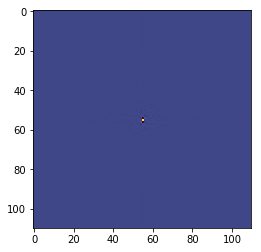

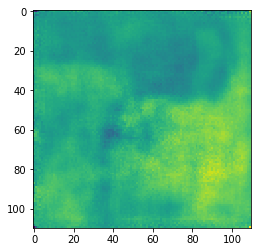

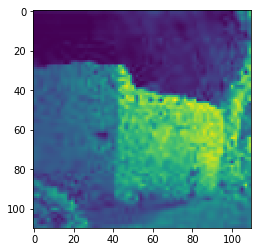

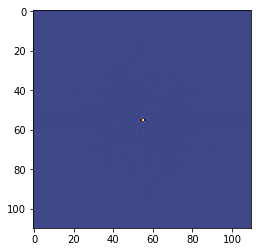

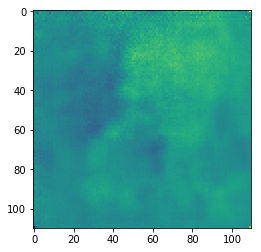

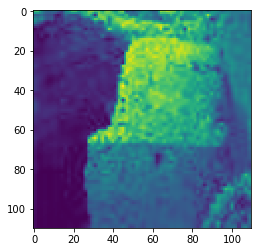

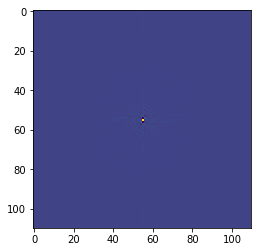

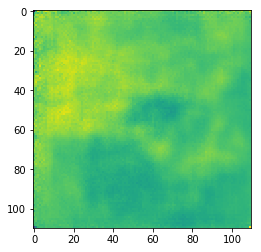

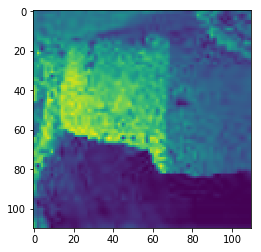

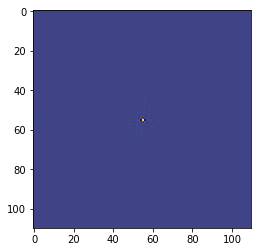

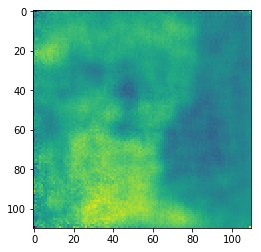

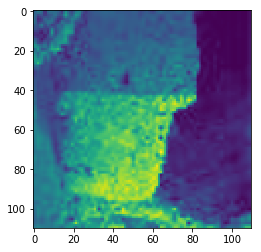

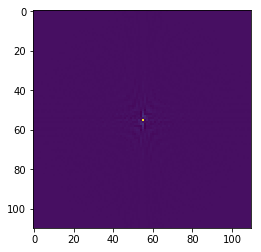

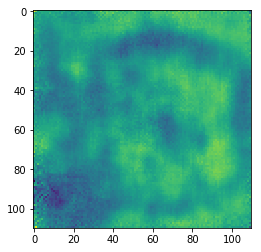

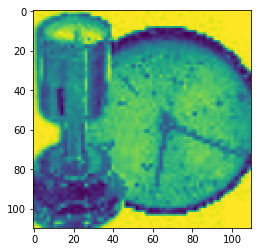

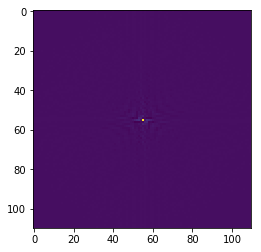

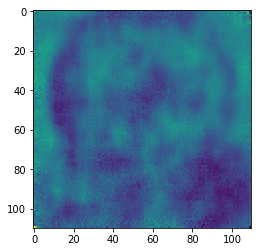

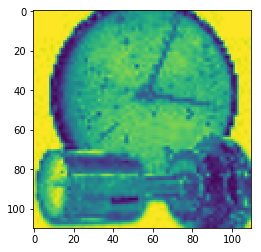

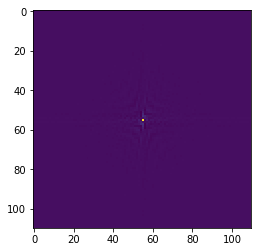

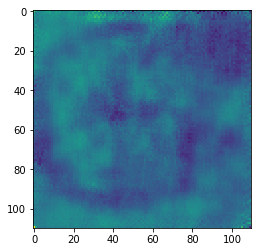

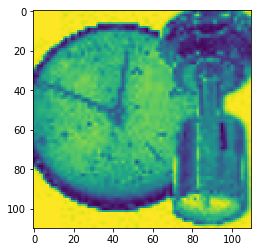

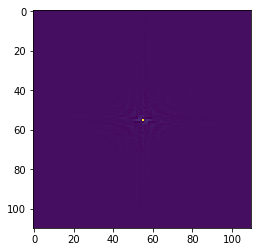

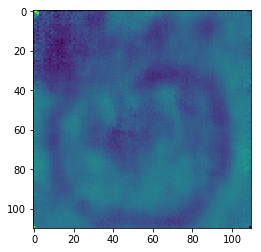

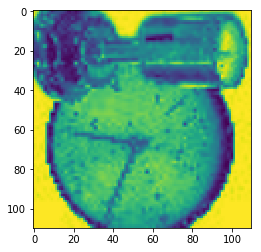

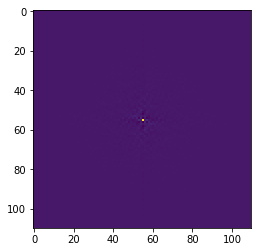

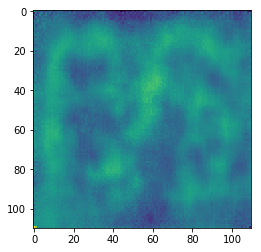

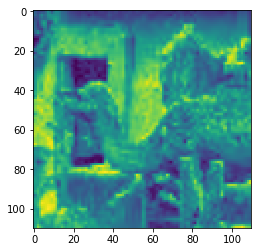

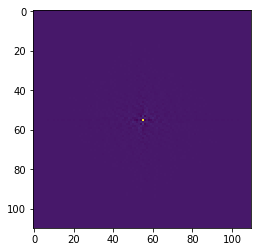

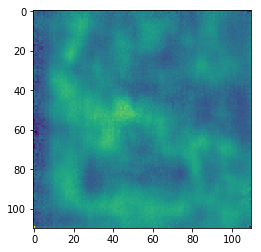

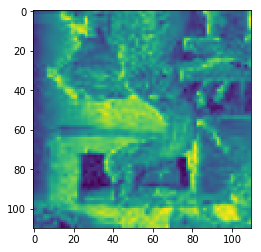

In [26]:
j = 100
out = predictor(X_train[j:j+10])

for i in range(10):
    plt.imshow(X_train[j+i][:, :, 0])
    plt.show()    
    plt.imshow(out.data[i, 0])
    plt.show()
    plt.imshow(Y_train[j+i])
    plt.show()

In [29]:
import pickle

In [30]:
with open('./result/trials.pkl', mode='wb') as f:
    pickle.dump(study.trials, f)

In [31]:
with open('./result/trials.pkl', mode='rb') as f:
    data = pickle.load(f)